In [1]:
import pickle
import sys
from tqdm import tqdm
import numpy as np
import sys
sys.path.append('..')
import eval
import numpy as np

In [2]:
DATASET = "concept_properties" # "feature_norms", "memory_colors"

In [3]:
noun2prop = pickle.load(open(f"../data/datasets/{DATASET}/noun2property/noun2prop.p", "rb"))
gpt3_predicts = {line.split()[0]:line.split()[1:] for line in open(f"../data/datasets/{DATASET}/GPT3/gpt3_predicts.txt", "rb").readlines()}
roberta_predicts = pickle.load(open(f"../output/output_{DATASET}/roberta-large+singular_generally.p", "rb"))
bert_predicts = pickle.load(open(f"../output/output_{DATASET}/bert-large-uncased+plural_most.p", "rb"))
vilt_predicts = pickle.load(open(f"../output/output_{DATASET}/vilt+plural+10.p", "rb"))
clip_predicts = pickle.load(open(f"../data/datasets/{DATASET}/CLIP/clip_scores.p", "rb"))
combined_predicts = pickle.load(open(f"../data/datasets/{DATASET}/CEM/combine_predicts.p", "rb"))
pred_combined_predicts = pickle.load(open(f"../output/output_{DATASET}/pred_combine_scores.p", "rb"))
gpt_predicts = pickle.load(open(f"../output/output_{DATASET}/gpt2-large+plural_most.p", "rb"))

In [4]:
candidate_adjs = []
for noun, props in noun2prop.items():
    candidate_adjs += props
candidate_adjs = list(set(candidate_adjs))

In [5]:
CSLB_data = pickle.load(open("../data/datasets/concept_properties/raw_data/CSLB_data.p", "rb"))
prop2type = {}
for data in CSLB_data:
    if data[-2].lower() not in prop2type:
        prop2type[data[-2].lower()] = data[1]
all_types = ['visual perceptual', 'other perceptual', 'functional', 'encyclopaedic']

In [6]:
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

concreteness = {w: c / 5 for w, c in pickle.load(open("../data/concreteness/word2concreteness.M.p", "rb")).items()}
all_words = list(concreteness.keys())
prop2concretness = {}
for prop in tqdm(candidate_adjs):
    if prop in concreteness:
        prop2concretness[prop] = concreteness[prop]
    else:
        sims = []
        for word in all_words:
            sims.append((word, similar(word, prop)))
        sims.sort(key=lambda x: x[1], reverse=True)
        prop2concretness[prop] = concreteness[sims[0][0]]

100%|██████████| 400/400 [01:46<00:00,  3.76it/s]


In [ ]:
clip_ranks = eval.evaluate_rank(clip_predicts, noun2prop, True)
roberta_ranks = eval.evaluate_rank(roberta_predicts, noun2prop, True)
bert_ranks = eval.evaluate_rank(bert_predicts, noun2prop, True)
gpt_ranks = eval.evaluate_rank(gpt_predicts, noun2prop, True)
vilt_ranks = eval.evaluate_rank(vilt_predicts, noun2prop, True)
combine_ranks = eval.evaluate_rank(combined_predicts, noun2prop, True)
pred_combine_ranks = eval.evaluate_rank(pred_combined_predicts, noun2prop, True)

In [16]:
prop2differs = {prop: [] for prop in candidate_adjs}
for i in range(len(combine_ranks)):
    prop, c_rank = combine_ranks[i]
    _, r_rank = roberta_ranks[i]
    prop2differs[prop].append(r_rank - c_rank)

points = []
for prop, scores in prop2differs.items():
    points.append((prop2concretness[prop], np.max(scores)))

points.sort(key=lambda x: x[0])

In [17]:
pred_prop2differs = {prop: [] for prop in candidate_adjs}
for i in range(len(pred_combine_ranks)):
    prop, c_rank = pred_combine_ranks[i]
    _, r_rank = roberta_ranks[i]
    pred_prop2differs[prop].append(r_rank - c_rank)

pred_points = []
for prop, scores in pred_prop2differs.items():
    pred_points.append((prop2concretness[prop], np.max(scores)))

pred_points.sort(key=lambda x: x[0])

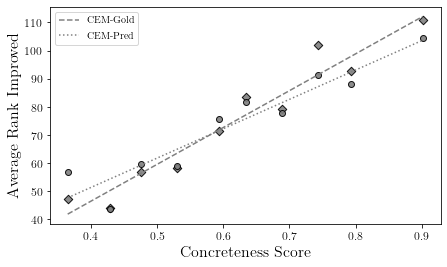

In [24]:
import math
import statistics
x = []
y = []
gap = 40
for i in range(len(points) // gap):
    current_points = points[i * gap : (i + 1) * gap]
    batch_xs = [b[0] for b in current_points]
    batch_ys = [b[1] for b in current_points]
    x.append(np.mean(batch_xs))
    y.append(np.mean(batch_ys))
x = np.array(x)
y = np.array(y)
m, b = np.polyfit(x, y, 1)


x_ = []
y_ = []
gap = 40
for i in range(len(pred_points) // gap):
    current_points = pred_points[i * gap : (i + 1) * gap]
    batch_xs = [b[0] for b in current_points]
    batch_ys = [b[1] for b in current_points]
    x_.append(np.mean(batch_xs))
    y_.append(np.mean(batch_ys))
x_ = np.array(x_)
y_ = np.array(y_)
m_, b_ = np.polyfit(x_, y_, 1)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(x, m*x + b, color = 'gray', linestyle = 'dashed', label='CEM-Gold')
plt.scatter(x, y, marker='D', alpha=0.9, color='gray', edgecolors='black')

plt.plot(x_, m_*x_ + b_, color = 'gray', linestyle = 'dotted', label='CEM-Pred')
plt.scatter(x_, y_, marker='o', alpha=0.9, color='gray', edgecolors='black')

plt.xlabel("Concreteness Score", fontsize=16)
plt.ylabel("Average Rank Improved", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim(20, 120)
# plt.xlim(0.3, 1.0)
plt.legend()
plt.savefig('CSLB_concretness_vs_rank.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.show()

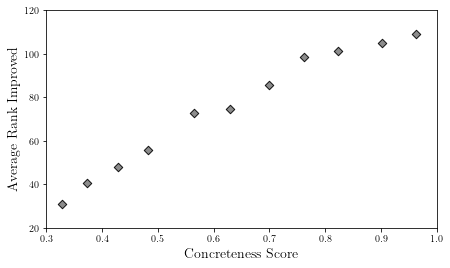

In [94]:
import math
import statistics
x = []
y = []
e = []
for i in range(4, 22):
    thres_low = (i - 1) * 0.07
    thres_high = (i + 1) * 0.07
    batch = []
    for point in points:
        if thres_low < point[0] < thres_high:
            batch.append(point)
    if batch == []:
        continue
    batch_xs = [b[0] for b in batch]
    batch_ys = [b[1] for b in batch]
    x.append(np.mean(batch_xs))
    y.append(np.mean(batch_ys))
    # e.append(math.sqrt(np.std(batch_ys)))
    # e.append(statistics.stdev(batch_ys))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams["font.family"] = "Times New Roman"


plt.scatter(x, y, marker='D', alpha=0.9, color='gray', edgecolors='black')
plt.xlabel("Concreteness Score", fontsize=14)
plt.ylabel("Average Rank Improved", fontsize=14)
plt.ylim(20, 120)
plt.xlim(0.3, 1.0)
plt.savefig('CSLB_concretness_vs_rank.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.show()

In [25]:
type2props = {prop_type: set() for prop_type in all_types}
for adj in candidate_adjs:
    try:
        type2props[prop2type[adj]].add(adj)
    except:
        continue

In [26]:
for type, props in type2props.items():
    print(type, len(props))

visual perceptual 94
other perceptual 75
functional 28
encyclopaedic 177


In [27]:
def get_mrr_each_type(ranks):
    type2rrs = {prop_type: [] for prop_type in all_types}
    for prop, rank in ranks:
        if prop2type[prop] in all_types:
            type2rrs[prop2type[prop]].append(1 / rank)
    return {prop_type: np.mean(np.sort(rrs)) for prop_type, rrs in type2rrs.items()}

In [28]:
roberta_results = get_mrr_each_type(roberta_ranks)
bert_results = get_mrr_each_type(bert_ranks)
clip_results = get_mrr_each_type(clip_ranks)
gpt_results = get_mrr_each_type(gpt_ranks)
vilt_results = get_mrr_each_type(vilt_ranks)
combine_results = get_mrr_each_type(combine_ranks)

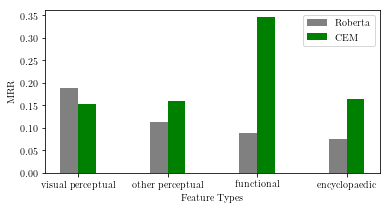

In [32]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (6,3)
# create data
x = 2 * np.arange(4)
y1 = list(gpt_results.values())
y2 = list(combine_results.values())
width = 0.4
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='gray')
plt.bar(x+0.2, y2, width, color='green')

plt.xticks(x, all_types)
plt.xlabel("Feature Types")
plt.ylabel("MRR")
plt.legend(["Roberta", "CEM"])
plt.savefig('distribution.png', format='png', dpi=600, bbox_inches='tight')
plt.show()